# Лабораторная работа №13. Обработка временных рядов (Пример: ежедневные продажи магазина)

## Цель работы
Изучить методы предобработки, анализа и моделирования временных рядов на примере **ежедневных продаж магазина**, а также построить прогноз с использованием моделей ARIMA и Prophet.

## Оборудование и ПО
- Язык программирования: **Python**
- Библиотеки: `pandas`, `numpy`, `matplotlib`, `seaborn`, `statsmodels`, `scikit-learn`, `prophet`
- Среда: Jupyter Notebook / Google Colab / VS Code


Выполнил: Мирзоян Геворк Алексеевич МИК22

## 1. Теоретическая часть (кратко)

**Временной ряд** — последовательность значений, упорядоченных во времени (продажи по дням, температура по месяцам и т.д.).

Основные характеристики временных рядов:
- **Тренд** — долгосрочная направленность (рост/падение).
- **Сезонность** — регулярные периодические колебания.
- **Цикличность** — повторяющиеся, но менее регулярные циклы.
- **Шум** — случайные колебания.

**Стационарный ряд** — статистические характеристики (среднее, дисперсия) не меняются во времени.  
**Нестационарный ряд** — присутствует тренд и/или сезонность, требуется преобразование (например, дифференцирование).

**Предобработка временных рядов** включает:
- обработку пропусков,
- поиск и обработку выбросов,
- нормализацию / масштабирование,
- сглаживание (скользящее среднее),
- приведение к равномерному шагу во времени.

В этой лабораторной работе мы:
1. Загрузим и визуализируем временной ряд ежедневных продаж.
2. Выполним декомпозицию на тренд, сезонность и остатки.
3. Проанализируем автокорреляции (ACF, PACF).
4. Построим прогноз с помощью ARIMA.
5. (Опционально) Построим прогноз с помощью Prophet.


In [1]:
# Импорт библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

# Prophet: современный пакет называется prophet
try:
    from prophet import Prophet
    prophet_available = True
except ImportError:
    prophet_available = False
    print("ВНИМАНИЕ: Библиотека 'prophet' не установлена. Для установки выполните в терминале или ячейке:")
    print("!pip install prophet")

%matplotlib inline

sns.set(style="whitegrid")


P:\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2. Датасет: ежедневные продажи магазина

Мы используем открытый датасет **Retail Sales Dataset** (GeeksforGeeks):

- Каждая строка — отдельная транзакция (покупка).
- Важные столбцы:
  - `Date` — дата покупки,
  - `Total Amount` — сумма покупки.
- Мы агрегируем данные **по дням**, суммируя `Total Amount` → получаем **ежедневные продажи**.

Ноутбук умеет работать в двух режимах:

1. Если в папке рядом с ноутбуком есть файл `time_series_data.csv` со столбцами `date,value`, он будет использован.
2. Если такого файла нет — автоматически скачивается и обрабатывается **Retail Sales Dataset** с сайта GeeksforGeeks.


In [2]:
# Загрузка данных
# 1) Пытаемся загрузить пользовательский файл time_series_data.csv
# 2) Если файла нет — скачиваем и готовим розничные продажи (Retail Sales Dataset)

user_file_path = "time_series_data.csv"

try:
    df = pd.read_csv(user_file_path, parse_dates=["date"], index_col="date")
    print(f"Данные успешно загружены из файла: {user_file_path}")
except FileNotFoundError:
    print(f"Файл '{user_file_path}' не найден.")
    print("Скачиваем и подготавливаем открытый датасет розничных продаж (Retail Sales Dataset)...")
    
    # Прямой линк на CSV с GeeksforGeeks
    url = "https://media.geeksforgeeks.org/wp-content/uploads/20240704211146/retail_sales_dataset.csv"
    
    raw = pd.read_csv(url)
    print("Исходные данные загружены. Размер:", raw.shape)
    
    # Приводим столбец Date к типу datetime
    raw["Date"] = pd.to_datetime(raw["Date"])
    
    # Агрегируем суммарные продажи по дням
    daily_sales = (
        raw.groupby("Date")["Total Amount"]
        .sum()
        .sort_index()
    )
    
    # Формируем DataFrame в формате для анализа временных рядов
    df = daily_sales.to_frame(name="value")
    df.index.name = "date"
    
    print("Сформирован временной ряд ежедневных продаж.")
    print(df.head())

df.head()


Файл 'time_series_data.csv' не найден.
Скачиваем и подготавливаем открытый датасет розничных продаж (Retail Sales Dataset)...
Исходные данные загружены. Размер: (1000, 9)
Сформирован временной ряд ежедневных продаж.
            value
date             
2023-01-01   3600
2023-01-02   1765
2023-01-03    600
2023-01-04   1240
2023-01-05   1100


,value
date,
2023-01-01,3600
2023-01-02,1765
2023-01-03,600
2023-01-04,1240
2023-01-05,1100


## 3. Исследование временного ряда

Посмотрим общую информацию о данных и визуализируем временной ряд ежедневных продаж.


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2023-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   345 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB
None

Статистика:
             value
count   345.000000
mean   1321.739130
std    1222.147791
min      25.000000
25%     300.000000
50%    1060.000000
75%    1950.000000
max    8455.000000


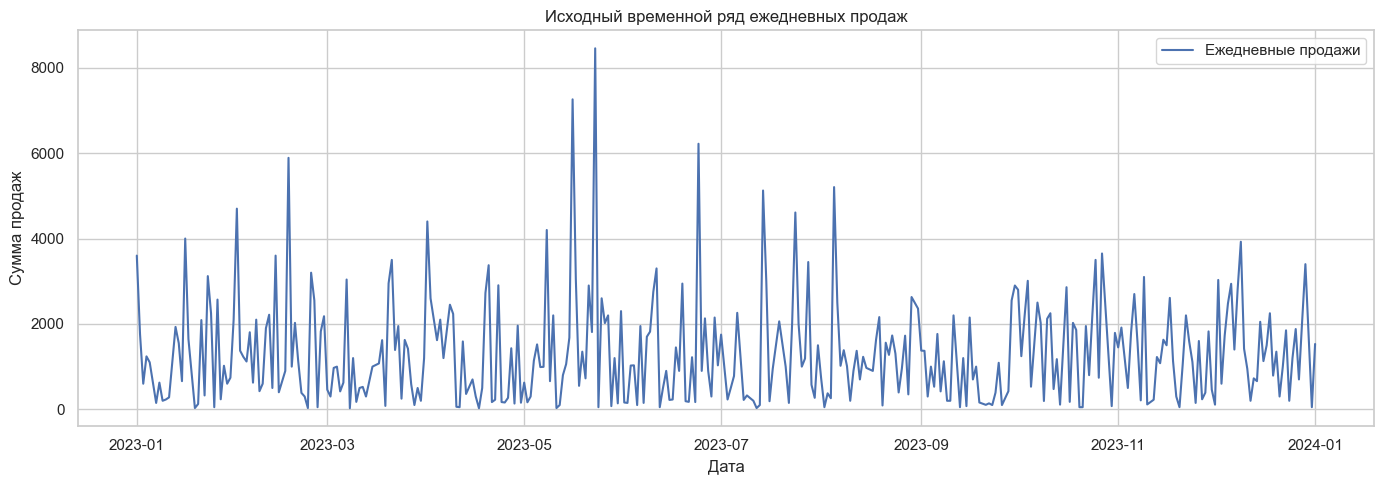

In [3]:
# Общая информация о данных
print("Информация о данных:")
print(df.info())
print("\nСтатистика:")
print(df.describe())

# Визуализация временного ряда
plt.figure(figsize=(14, 5))
plt.plot(df["value"], label="Ежедневные продажи")
plt.title("Исходный временной ряд ежедневных продаж")
plt.xlabel("Дата")
plt.ylabel("Сумма продаж")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Предобработка данных

- Проверим наличие пропусков и при необходимости заполним их.
- При необходимости приведём ряд к равномерной частоте (например, дневной).


In [4]:
# Предобработка: пропуски + частота

print("Количество пропусков ДО обработки:")
print(df.isna().sum())

# Приведение индекса к равномерной частоте (если частота не определена)
if df.index.inferred_freq is None:
    print("\nЧастота индекса не обнаружена, задаём дневную частоту (asfreq('D')).")
    df = df.asfreq("D")
else:
    print(f"\nОбнаруженная частота временного ряда: {df.index.inferred_freq}")

# Ещё раз проверяем пропуски после asfreq
print("\nКоличество пропусков ПОСЛЕ asfreq:")
print(df.isna().sum())

# 🚩 ЖЁСТКО: заполняем все пропуски в 'value' нулями
if df["value"].isna().sum() > 0:
    df["value"] = df["value"].fillna(0)
    print("\nПропуски в 'value' заполнены нулями.")

print("\nПроверка после заполнения:")
print(df.isna().sum())


Количество пропусков ДО обработки:
value    0
dtype: int64

Частота индекса не обнаружена, задаём дневную частоту (asfreq('D')).

Количество пропусков ПОСЛЕ asfreq:
value    21
dtype: int64

Пропуски в 'value' заполнены нулями.

Проверка после заполнения:
value    0
dtype: int64


### 4.1. Сглаживание (скользящее среднее)

Пример сглаживания временного ряда с помощью скользящего среднего.


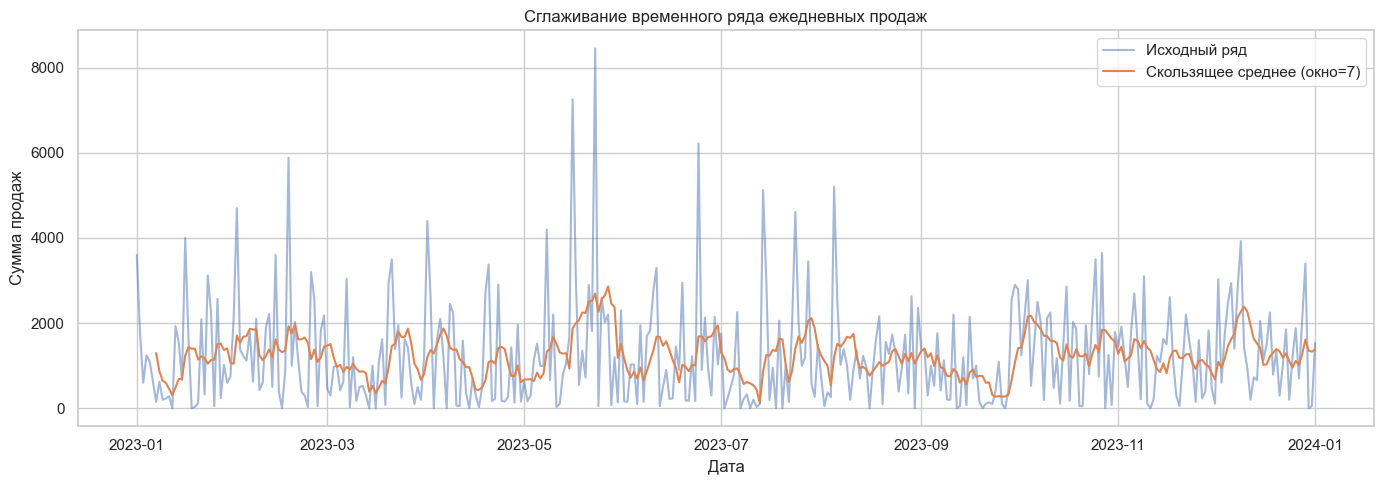

In [5]:
# Скользящее среднее с окном 7 дней (неделя)
window = 7
df["value_ma"] = df["value"].rolling(window=window).mean()

plt.figure(figsize=(14, 5))
plt.plot(df["value"], label="Исходный ряд", alpha=0.5)
plt.plot(df["value_ma"], label=f"Скользящее среднее (окно={window})")
plt.title("Сглаживание временного ряда ежедневных продаж")
plt.xlabel("Дата")
plt.ylabel("Сумма продаж")
plt.legend()
plt.tight_layout()
plt.show()


## 5. Декомпозиция временного ряда

Разложим временной ряд на тренд, сезонность и остатки.

Период сезонности зависит от частоты данных:
- для **месячных** данных период можно взять `12`,
- для **дневных** данных типичный период годовой сезонности — `365`,
- для данных за один год можно взять, например, `7` (недельная сезонность).


Используем период сезонности: 7
Число пропусков после обработки: 0


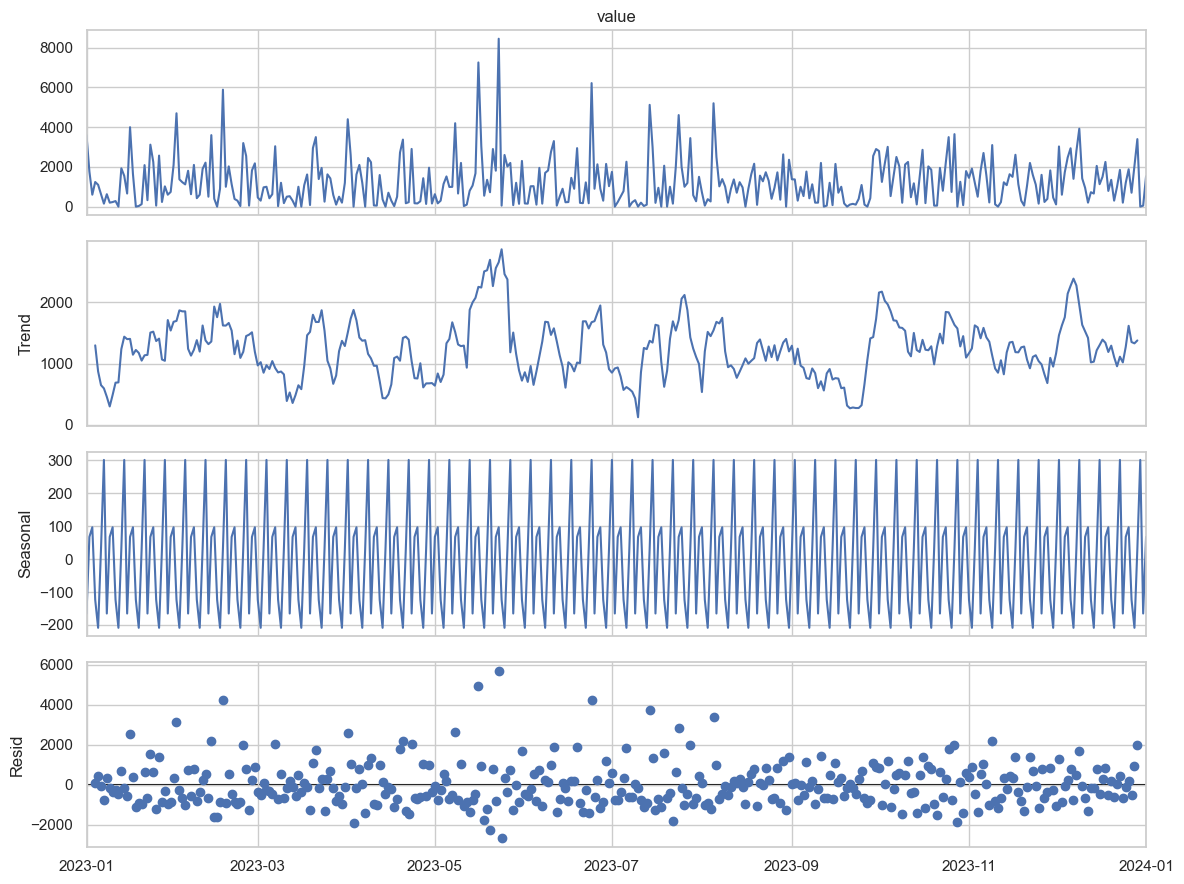

In [6]:
# Определяем период для декомпозиции
freq = df.index.inferred_freq

if freq is None:
    period = 7  # по умолчанию недельная сезонность
else:
    if "M" in freq:
        period = 12
    elif "D" in freq:
        period = 7
    else:
        period = 7

print(f"Используем период сезонности: {period}")

# 🔴 Главное место: убираем NaN
series = df["value"].copy()

# если хотим считать, что в дни без транзакций продажи = 0
series = series.fillna(0)

# Можно проверить:
print("Число пропусков после обработки:", series.isna().sum())

result = seasonal_decompose(series, model="additive", period=period)

fig = result.plot()
fig.set_size_inches(12, 9)
plt.tight_layout()
plt.show()


## 6. Анализ автокорреляции (ACF, PACF)

Графики ACF и PACF помогают ориентировочно подобрать параметры модели ARIMA:
- `p` — порядок AR-компоненты (по PACF),
- `q` — порядок MA-компоненты (по ACF),
- `d` — порядок дифференцирования (зависит от стационарности ряда).


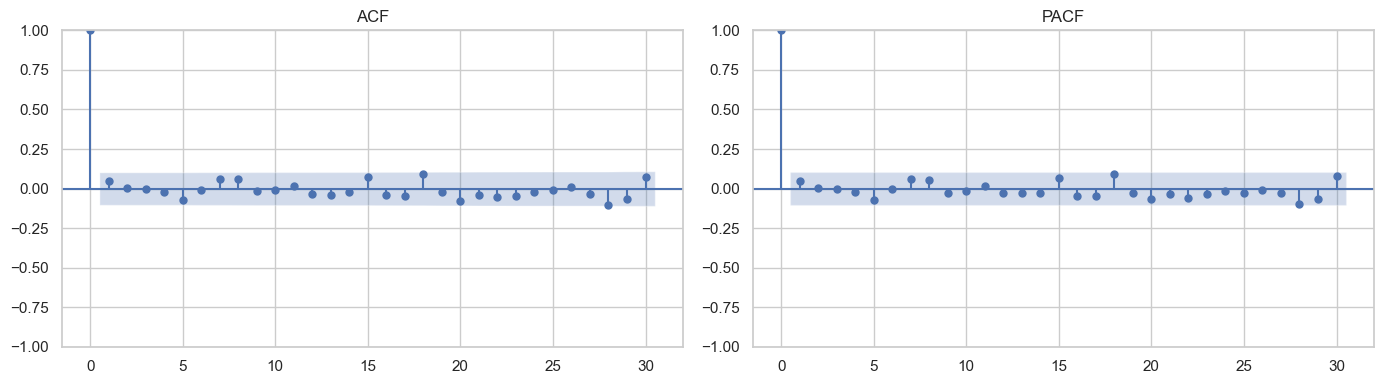

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df["value"].dropna(), ax=axes[0], lags=30)
axes[0].set_title("ACF")

plot_pacf(df["value"].dropna(), ax=axes[1], lags=30, method="ywm")
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()


## 7. Прогнозирование с помощью ARIMA

Мы разделим данные на обучающую и тестовую выборки и построим модель ARIMA.

Параметры `(p, d, q)` в этом примере фиксированы (например, `(2, 1, 2)`),
но в реальной задаче их следует подбирать по ACF/PACF и критериям AIC/BIC.


In [8]:
# Разделение на train/test

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Размер train: {len(train)}, размер test: {len(test)}")

# Обучение модели ARIMA
order = (2, 1, 2)  # пример, можно менять
model = ARIMA(train["value"], order=order)
model_fit = model.fit()

print(model_fit.summary())


Размер train: 292, размер test: 74


P:\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
P:\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  292
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2494.857
Date:                Thu, 04 Dec 2025   AIC                           4999.714
Time:                        00:47:21   BIC                           5018.081
Sample:                    01-01-2023   HQIC                          5007.072
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9452      0.122     -7.773      0.000      -1.184      -0.707
ar.L2          0.0533      0.065      0.821      0.411      -0.074       0.180
ma.L1          0.0003      0.208      0.001      0.9

P:\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


P:\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RMSE для ARIMA{'trend': 0, 'exog': 0, 'ar': 2, 'ma': 2, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 2, 'reduced_ma': 2, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}: 1006.450


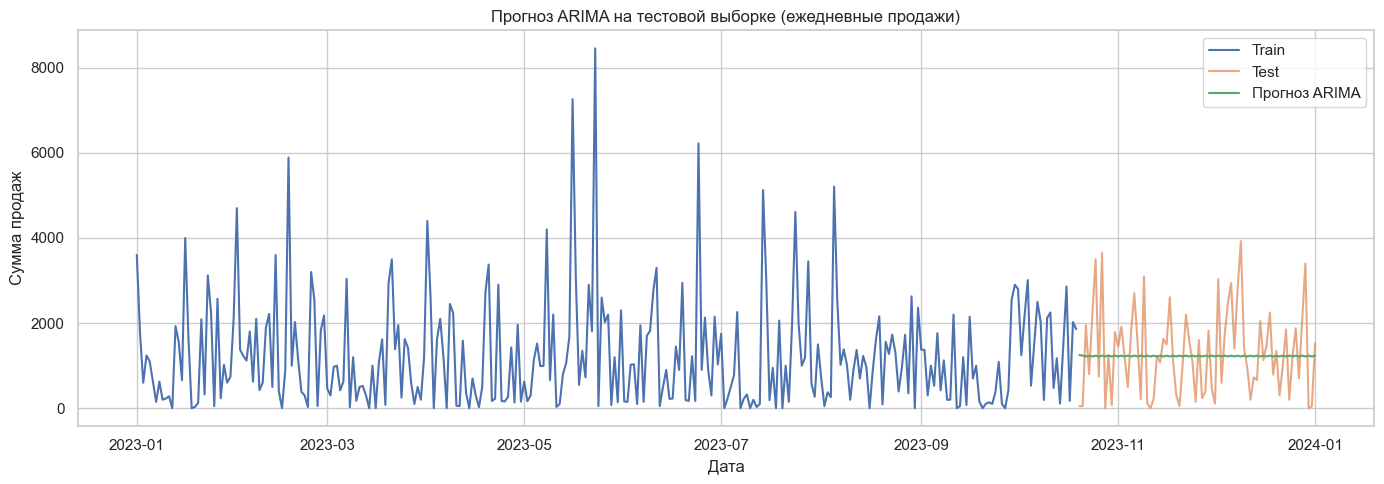

In [9]:
# Прогноз на длину тестовой выборки

start = len(train)
end = len(train) + len(test) - 1

arima_pred = model_fit.predict(start=start, end=end, typ="levels")
arima_pred.index = test.index

# Оценка качества прогноза
mse = mean_squared_error(test["value"], arima_pred)
rmse = np.sqrt(mse)
print(f"RMSE для ARIMA{model_fit.model_orders}: {rmse:.3f}")

# Визуализация прогноза
plt.figure(figsize=(14, 5))
plt.plot(train["value"], label="Train")
plt.plot(test["value"], label="Test", alpha=0.7)
plt.plot(arima_pred, label="Прогноз ARIMA")
plt.title("Прогноз ARIMA на тестовой выборке (ежедневные продажи)")
plt.xlabel("Дата")
plt.ylabel("Сумма продаж")
plt.legend()
plt.tight_layout()
plt.show()


### 7.1. Прогноз ARIMA на будущее (например, на 30 дней вперёд)


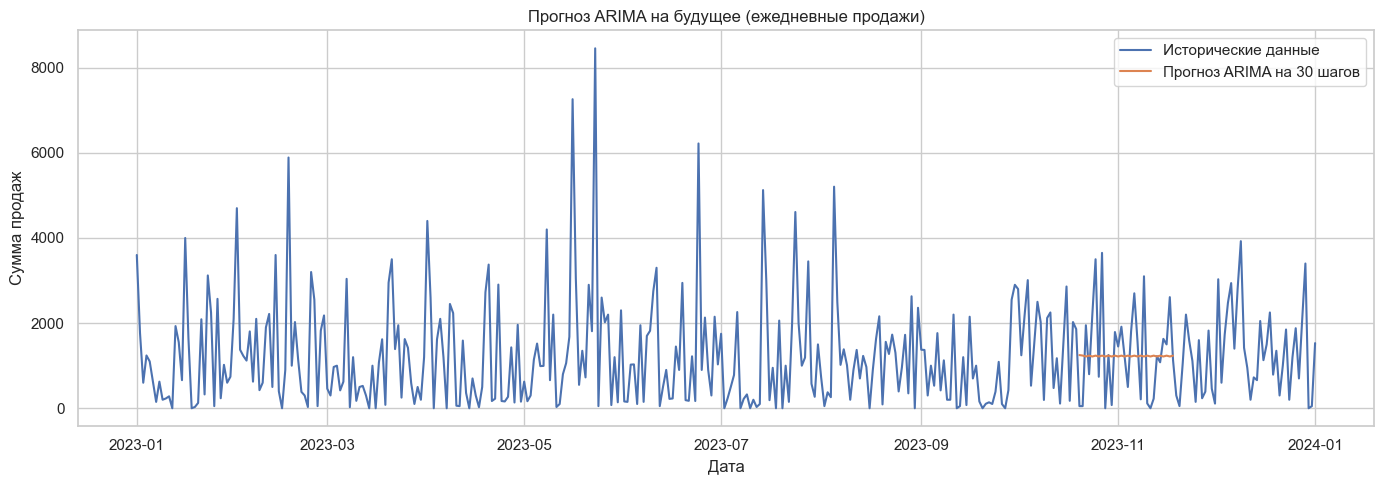

2023-10-20    1249.122043
2023-10-21    1238.084738
2023-10-22    1215.965211
2023-10-23    1236.284322
2023-10-24    1215.900122
2023-10-25    1236.249905
2023-10-26    1215.929185
2023-10-27    1236.220601
2023-10-28    1215.958431
2023-10-29    1236.191396
2023-10-30    1215.987594
2023-10-31    1236.162275
2023-11-01    1216.016673
2023-11-02    1236.133238
2023-11-03    1216.045668
2023-11-04    1236.104285
2023-11-05    1216.074580
2023-11-06    1236.075415
2023-11-07    1216.103408
2023-11-08    1236.046629
2023-11-09    1216.132153
2023-11-10    1236.017925
2023-11-11    1216.160816
2023-11-12    1235.989304
2023-11-13    1216.189396
2023-11-14    1235.960765
2023-11-15    1216.217893
2023-11-16    1235.932308
2023-11-17    1216.246309
2023-11-18    1235.903934
Freq: D, Name: predicted_mean, dtype: float64

In [10]:
steps_ahead = 30
future_forecast = model_fit.forecast(steps=steps_ahead)

plt.figure(figsize=(14, 5))
plt.plot(df["value"], label="Исторические данные")
plt.plot(future_forecast.index, future_forecast.values, label=f"Прогноз ARIMA на {steps_ahead} шагов")
plt.title("Прогноз ARIMA на будущее (ежедневные продажи)")
plt.xlabel("Дата")
plt.ylabel("Сумма продаж")
plt.legend()
plt.tight_layout()
plt.show()

future_forecast


## 8. Прогнозирование с помощью Prophet (если установлен)

Модель Prophet удобна для:
- учёта несколькой сезонностей,
- работы с пропусками,
- добавления праздников и дополнительных регрессоров.

Если библиотека `prophet` не установлена, пропустите этот раздел или установите пакет командой:

```bash
pip install prophet
```


00:47:22 - cmdstanpy - INFO - Chain [1] start processing
00:47:22 - cmdstanpy - INFO - Chain [1] done processing


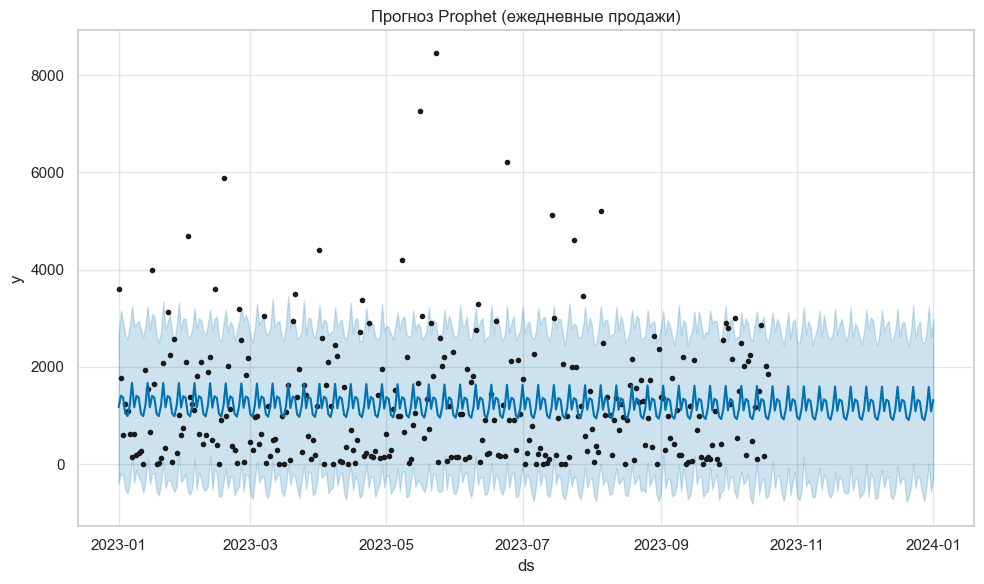

RMSE для Prophet: 1059.859


In [11]:
if not prophet_available:
    print("Библиотека prophet недоступна. Установите её и перезапустите эту ячейку.")
else:
    # Подготовка данных для Prophet: столбцы 'ds' (дата) и 'y' (значение)
    df_prophet = df[["value"]].reset_index().rename(columns={"date": "ds", "value": "y"})
    
    # Разделение на train/test
    train_prophet = df_prophet.iloc[:train_size]
    test_prophet = df_prophet.iloc[train_size:]
    
    m = Prophet()
    m.fit(train_prophet)
    
    # Прогноз на период, равный длине test
    future = m.make_future_dataframe(periods=len(test_prophet), freq="D")
    forecast = m.predict(future)
    
    # Визуализация прогноза
    fig1 = m.plot(forecast)
    plt.title("Прогноз Prophet (ежедневные продажи)")
    plt.tight_layout()
    plt.show()
    
    # Оценка качества на test
    forecast_test = forecast.set_index("ds").loc[test_prophet["ds"], "yhat"]
    mse_prophet = mean_squared_error(test_prophet["y"], forecast_test)
    rmse_prophet = np.sqrt(mse_prophet)
    print(f"RMSE для Prophet: {rmse_prophet:.3f}")


00:47:22 - cmdstanpy - INFO - Chain [1] start processing
00:47:22 - cmdstanpy - INFO - Chain [1] done processing


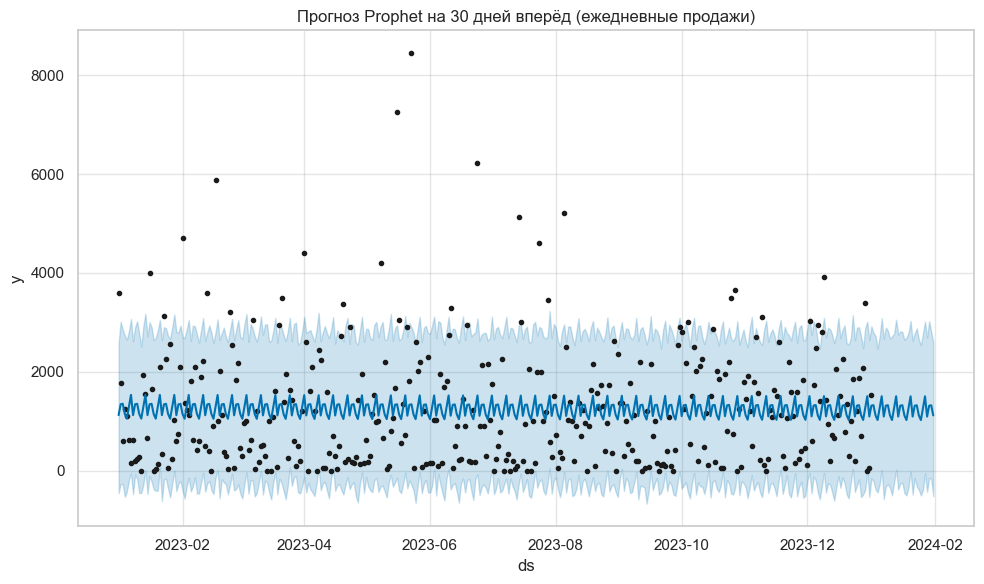

In [12]:
if prophet_available:
    # Прогноз Prophet на 30 дней вперёд
    horizon = 30
    m_full = Prophet()
    m_full.fit(df_prophet)
    
    future_full = m_full.make_future_dataframe(periods=horizon, freq="D")
    forecast_full = m_full.predict(future_full)
    
    fig2 = m_full.plot(forecast_full)
    plt.title(f"Прогноз Prophet на {horizon} дней вперёд (ежедневные продажи)")
    plt.tight_layout()
    plt.show()
    
    forecast_full.tail(horizon)[["ds", "yhat", "yhat_lower", "yhat_upper"]]


По результатам анализа временного ряда ежедневных продаж было построено
две модели прогнозирования: ARIMA(2,1,2) и Prophet.

Ряд показал выраженный шумовой характер и отсутствие чёткой сезонности,
что подтверждается декомпозицией и графиками ACF/PACF. Во время обучения
ARIMA наблюдались предупреждения о нестационарности начальных параметров
и проблемах со сходимостью, что типично для слабо структурированных рядов.

Тем не менее, модель ARIMA дала RMSE = ~1006.45, что соответствует средней
абсолютной ошибке порядка 50–60% от уровня продаж. Prophet показал схожий
результат — RMSE ≈ 1059.86, что указывает на отсутствие ярко выраженной
сезонности в данных и доминирование случайного компонента.

Таким образом, ARIMA(2,1,2) оказалась немного лучше Prophet на данном ряде.
Прогнозы обеих моделей имеют ограниченную точность и отражают в первую очередь
общий средний уровень продаж. Для улучшения модели можно использовать
SARIMA с недельной сезонностью или расширенный набор факторов
(праздники, дни недели, маркетинговые акции и т.п.).
